# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
"""
Change directory to where this file is located
"""
%cd /content/drive/MyDrive/MLDL1_HW4

/content/drive/MyDrive/MLDL1_HW4


In [ ]:
import math
import random
from pathlib import Path
import sys

from data.data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
"""
import modules you need
"""
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Util

**Do NOT Modify** code blocks in this section

In [ ]:
SEED = 1234
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
def train(model, iterator, optimizer, loss_fn, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)
            output = model(src, trg)
            loss = loss_fn(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def plot_history(history):
    plt.figure(figsize=(2 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_PPL'], label="train_PPL")
    plt.plot(history['val_PPL'], label="val_PPL")
    plt.xlabel("iterations")
    plt.ylabel("PPL")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [ ]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7 # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [ ]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length = max_length
        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']

        print("\n")
        print("This is data example")
        print(random.choice(self.pairs))

        print("\n")
        print("This is index of PAD token for each language")
        print(f"fra {self.output_lang.word2index['PAD']}")
        print(f"eng {self.input_lang.word2index['PAD']}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)

    def collate_fn(self, data):
        x_batch = []; y_batch = []

        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))

        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['je suis votre medecin .', 'i m your doctor .']


This is index of PAD token for each language
fra 2803
eng 4345


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


## Implement LSTM Seq2Seq Model

In [ ]:
class LSTMEncoder(nn.Module):

    def __init__(self, in_dim, emb_dim, hid_dim):
        super(LSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)

    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need. (e.g. hidden states of encoder, etc.)
        '''
        ################### YOUR CODE ###################
        embedded_x = self.embedding(input).to(DEVICE)
        hiddens, (hidden, cell) = self.lstm(embedded_x, (hidden, cell))
        return hiddens, hidden, cell
        #################################################

In [ ]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout

        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hid_dim, out_dim)

    def forward(self, input, hidden, cell):

        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention
        Before implementing LSTM layer, make sure to feed the concatenated input into Linear and tanh activation layer.
        This will allow the concatenated input to be resized from (B, hid_dim + hid_dim) into (B, hid_dim)

        INPUT
        - input: a token of input sentence (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (N, emb_dim)
        - current hidden state
        - current cell state
        '''

        ################### YOUR CODE ###################
        hidden = hidden.unsqueeze(0)
        query = hidden # set query to calculate attention
        kv = self.enc_hiddens


        embedded_x = self.embedding(input)
        if self.training:
          dropout = nn.Dropout(self.dropout)
          embedded_x = dropout(embedded_x)

        score = kv @ query.permute(1,2,0)
        coeff = F.softmax(score, dim=2)
        value = (coeff.permute(0,2,1) @ kv).squeeze(1)

        query_concat = torch.cat([query, value.unsqueeze(0)], dim=2)
        query = self.fc(query_concat)

        hidden = self.tanh(query)

        hiddens, (hidden, cell) = self.lstm(embedded_x, (hidden, cell))


        y_hat = self.classifier(hiddens)
        #y_hat = F.log_softmax(oy_hat, dim=2)

        return y_hat, (hidden, cell)
        #################################################

In [ ]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)

        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)

    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)

        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of one-hot prediction (B, out_dim, max_len)
        '''
        ################### YOUR CODE ###################
        batch_size, mx_len = src.shape

        # Encoder
        h0 = torch.zeros(1, batch_size, self.hid_dim, requires_grad=True).to(DEVICE)
        c0 = torch.zeros(1, batch_size, self.hid_dim, requires_grad=True).to(DEVICE)

        hiddens, hidden, cell = self.encoder(src, h0, c0)

        # Decoder
        self.decoder.enc_hiddens = hiddens

        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words, requires_grad=True).to(self.device)

        input = trg[:, 0].unsqueeze(1)
        for t in range(1, mx_len+1): # for each t'th token, get decoder outputs
            hiddens, (hidden, cell) = self.decoder(input, hidden.squeeze(0), cell)
            input = hiddens.argmax(dim=-1)

            outputs[t-1] = hiddens.squeeze(1)

            # if self.training:
            #     input = trg[:, t-1].unsqueeze(1)
            # else:
            #     input = hiddens.argmax(dim=-1)
            # outputs[t-1] = hiddens.squeeze(1)
            #outputs[t-1] = F.one_hot(torch.max(hiddens, dim=1)[1])


        outputs = outputs.permute(1, 2, 0)

        return outputs
        #################################################

## Training

In [ ]:
'''
Q2 - (c)
Train your Seq2Seq model and plot perplexities and learning rates.
Upon successful training, the test perplexity should be less than 7.
Briefly report your hyperparameters and results on test dataset.
Make sure your results are printed in your submitted file.
'''

In [ ]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 512
emb_dim = 256
dropout = 0.4
learning_rate = 0.002
N_EPOCHS = 30
valid_every=10
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=1)

Epoch: 01
	Train Loss: 3.153 | Train PPL:  23.406
	 Val. Loss: 2.574 |  Val. PPL:  13.115
Epoch: 02
	Train Loss: 2.367 | Train PPL:  10.665
Epoch: 03
	Train Loss: 2.077 | Train PPL:   7.978
Epoch: 04
	Train Loss: 1.822 | Train PPL:   6.184
Epoch: 05
	Train Loss: 1.616 | Train PPL:   5.031
Epoch: 06
	Train Loss: 1.416 | Train PPL:   4.119
Epoch: 07
	Train Loss: 1.249 | Train PPL:   3.486
Epoch: 08
	Train Loss: 1.083 | Train PPL:   2.955
Epoch: 09
	Train Loss: 0.947 | Train PPL:   2.577
Epoch: 10
	Train Loss: 0.813 | Train PPL:   2.255
Epoch: 11
	Train Loss: 0.704 | Train PPL:   2.022
	 Val. Loss: 1.730 |  Val. PPL:   5.642
Epoch: 12
	Train Loss: 0.611 | Train PPL:   1.842
Epoch: 13
	Train Loss: 0.526 | Train PPL:   1.692
Epoch: 14
	Train Loss: 0.443 | Train PPL:   1.558
Epoch: 15
	Train Loss: 0.379 | Train PPL:   1.461
Epoch: 16
	Train Loss: 0.323 | Train PPL:   1.381
Epoch: 17
	Train Loss: 0.281 | Train PPL:   1.324
Epoch: 18
	Train Loss: 0.241 | Train PPL:   1.272
Epoch: 19
	Train Los

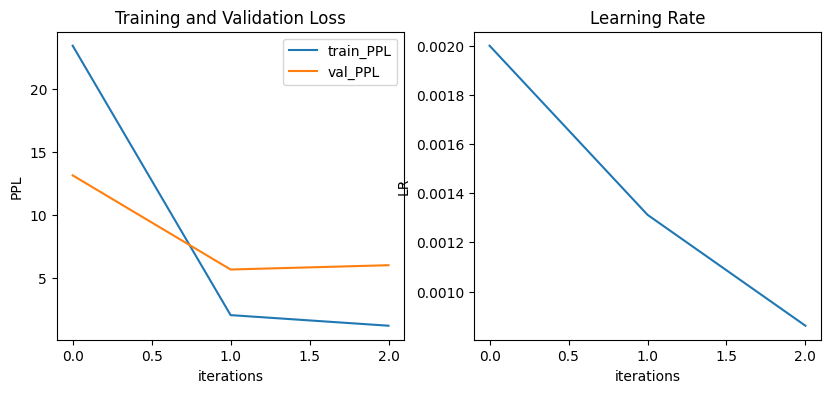

In [ ]:
# Train your model
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

    scheduler.step(valid_loss)

plot_history(history)

In [ ]:
# Test your model
torch.save(model.state_dict(), 'lstm-attn-model.pt')
loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 1.789 |  Test. PPL:   5.984


Briefly report your hyperparameters and results on test datasets.  

You Answer :
<Test Loss: 1.789, Test PPL: 5.984>
- hid_dim = 512
- emb_dim = 256
- dropout = 0.4
- learning_rate = 0.002
- N_EPOCHS = 30
- optimizer: AdamW
- scheduler: ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=1)
